In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as du
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import sidechainnet as scn
import random
import sklearn
import roma
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [25]:
data_eval = scn.load(casp_version=7, with_pytorch="dataloaders", 
                seq_as_onehot=True, aggregate_model_input=False,
               batch_size=1)
data = scn.load(casp_version=7, with_pytorch="dataloaders", 
                seq_as_onehot=True, aggregate_model_input=False,
               batch_size=24)

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.
SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


In [4]:
def get_seq_features(batch):
    '''
    Take a batch of sequence info and return the sequence (one-hot),
    evolutionary info and (phi, psi, omega) angles per position, 
    as well as position mask.
    Also return the distance matrix, and distance mask.
    '''
    str_seqs = batch.str_seqs # seq in str format
    seqs = batch.seqs # seq in one-hot format
    int_seqs = batch.int_seqs # seq in int format
    masks = batch.msks # which positions are valid
    lengths = batch.lengths # seq length
    evos = batch.evos # PSSM / evolutionary info
    angs = batch.angs[:,:,0:2] # torsion angles: phi, psi
    phi_cos = torch.cos(angs[:,:,0])
    phi_sin = torch.sin(angs[:,:,0])
    psi_cos = torch.cos(angs[:,:,1])
    psi_sin = torch.sin(angs[:,:,1])
    angs = torch.stack((phi_cos, phi_sin, psi_cos, psi_sin), dim = -1)
    
    # coords[:, 1, :] is c-alpha, coords[:, 0, :] is n, coords[:, 2, :] is c
    coords = batch.crds # seq coord info (all-atom)
    batch_c_alpha = []
    batch_n = []
    batch_c = []
    for i in range(coords.shape[0]):
        c_alpha = []
        n = []
        c = []
        c_alpha = [coords[i][cpos+1,:] for cpos in range(0, coords[i].shape[0]-1, 14)]
        n = [coords[i][cpos,:] for cpos in range(0, coords[i].shape[0]-1, 14)]
        c = [coords[i][cpos+2,:] for cpos in range(0, coords[i].shape[0]-1, 14)]
        batch_c_alpha.append(torch.stack(c_alpha))
        batch_n.append(torch.stack(n))
        batch_c.append(torch.stack(c))
    batch_c_alpha = torch.stack(batch_c_alpha)
    batch_n = torch.stack(batch_n)
    batch_c = torch.stack(batch_c)
    return seqs, evos, angs, masks, batch_c_alpha, batch_n, batch_c

In [5]:
class AttentionHead(nn.Module):
    '''
    An Attenton head for row/column attention
    '''
    def __init__(self, num_heads, c, c_z, c_m):
        super(AttentionHead, self).__init__()
        
        self.num_heads = num_heads
        self.c = c
        self.c_z = c_z
        
        #query key value
        self.q = nn.Linear(c_m, self.c, bias = False)
        self.k = nn.Linear(c_m, self.c, bias = False)
        self.v = nn.Linear(c_m, self.c, bias = False)
        
        #bias projects z from 128 to 1
        self.bias = nn.Linear(self.c_z, 1, bias = False)
        
    def forward(self, msa_rep, pair_rep, row):
        #get query key value
        query = self.q(msa_rep)
        key = self.k(msa_rep)
        value = self.v(msa_rep)
        
        out = torch.matmul(query,torch.transpose(key,1,2))/np.sqrt(self.c)
        if row: 
            b = self.bias(pair_rep).squeeze()
            out += b
        
        #softmax with respect to rows
        out = F.softmax(out, dim = 1)
        out = torch.matmul(out, value)
        
        return out

In [6]:
class rowColAtt(nn.Module):
    '''
    Compute the row or column attention given c, c_m, c_z, num_heads, row, and device.
    '''
    def __init__(self, c, c_m, c_z, num_heads, row, device):
        super(rowColAtt, self).__init__()
        
        self.row = row
        self.num_heads = num_heads
        self.device = device
        
        #attention heads
        self.mhsa = nn.ModuleList([AttentionHead(num_heads, c, c_z, c_m) for i in range(self.num_heads)])
        
        #project to c_msa
        self.fc1 = nn.Linear(c*num_heads, c_m)
        
        self.gate = nn.Sequential(nn.Linear(c_m, c), nn.Sigmoid())
        
    def forward(self, msa_rep, pair_rep):
        new_msa_rep = torch.empty(msa_rep.shape).to(self.device)
        for s in range(msa_rep.shape[1]):
            s_o = []
            gate = self.gate(msa_rep)
            for i, head in enumerate(self.mhsa):
                out = head(msa_rep[:,s,:,:], pair_rep, self.row)
                gate = self.gate(msa_rep[:,s,:,:])
                final = gate * out
                s_o.append(final)
                
            new_slice = torch.concat(s_o, dim = 2)
            new_slice = self.fc1(new_slice)
            new_msa_rep[:,s,:,:] = new_slice
            
        return new_msa_rep

In [7]:
class Outer_Prod_Mean(nn.Module):
    '''
    Finds the outer product mean between the pair-wise representation
    and the msa representation.
    The output is a n_res x n_res x 128 pair_rep
    '''
    def __init__(self, c, c_m, c_z, device):
        super(Outer_Prod_Mean, self).__init__()
        self.device = device
        
        #linear layer to project i[s] and j[s] to c dim
        self.fc1 = nn.Linear(c_m, c)
        self.fc2 = nn.Linear(c_m, c)
        
        #flatten the mean outer product to C*C
        self.flatten = nn.Flatten()
        
        #linear layer to project the outer product mean to 128 dim
        self.fc3 = nn.Linear(c*c, c_z)
        
        
    def forward(self, msa_rep, pair_rep):
        
        #project m to A and B
        new_pair_rep = torch.zeros(pair_rep.shape).to(self.device)
        
        for i in range(msa_rep.shape[2]):
            for j in range(msa_rep.shape[2]):
                a = self.fc1(msa_rep[:,:,i,:])
                b = self.fc2(msa_rep[:,:,j,:])
                outer = torch.einsum('bij,bik->bijk',a,b)
                out_mean = torch.mean(outer, dim = 1)
                out = self.flatten(out_mean)
                out = self.fc3(out)
                new_pair_rep[:,i,j,:] = out
                
        return new_pair_rep

In [8]:
class Mult_Attention(nn.Module):
    def __init__(self, c_z, c, out, device):
        '''
        Does incoming(default) multiplicative attention on a given pair_rep.
        out: set to False to do incoming attention
        '''
        super(Mult_Attention, self).__init__()
        self.device = device
        self.out = out
        self.ln = nn.LayerNorm(c_z)
        self.fc1 = nn.Linear(c_z, c)
        self.fc2 = nn.Linear(c_z, c)
        self.fc3 = nn.Linear(c, c_z)
        self.c = c
        self.c_z = c_z

        self.gate1 = nn.Sequential(nn.Linear(c_z, c), nn.Sigmoid())
        self.gate2 = nn.Sequential(nn.Linear(c_z, c), nn.Sigmoid())
        self.gate3 = nn.Sequential(nn.Linear(c_z, c_z), nn.Sigmoid())

    def forward(self, pair_rep):
        #Do a layer norm on pair_rep
        pair_rep = self.ln(pair_rep)
        Z = torch.zeros((pair_rep.shape[0], pair_rep.shape[1], pair_rep.shape[2], self.c)).to(self.device)
        #make A and B
        A = self.fc1(pair_rep)
        B = self.fc2(pair_rep)

        #Make gates for A and B
        gate_A = self.gate1(pair_rep)
        gate_B = self.gate2(pair_rep)
        gate_Z = self.gate3(pair_rep)

        #take dot product of A, B and their gates
        new_A = A * gate_A
        new_B = B * gate_B

        #transpose a and b if we are doing incoming attention
        if not self.out:
            new_A = torch.transpose(new_A, 1, 2)
            new_B = torch.transpose(new_B, 1, 2)

        for i in range(new_A.shape[1]):
            for j in range(new_B.shape[2]):
                Z[:,i,j] = (torch.sum((new_A[:,i,:] * new_B[:,j,:]), dim = 1))

        return self.fc3(Z) * gate_Z

In [9]:
class Tri_Attention(nn.Module):
    '''
    Does starting triangular attention by default.
    ending: set to true to do ending triangular attention
    '''
    def __init__(self, c, c_z, ending = False, num_heads = 4):
        super(Tri_Attention, self).__init__()
        self.ending = ending
        self.num_heads = num_heads
        self.c = c
        
        self.q = nn.ModuleList([nn.Linear(c_z, c) for i in range(num_heads)])
        self.k = nn.ModuleList([nn.Linear(c_z, c) for i in range(num_heads)])
        self.v = nn.ModuleList([nn.Linear(c_z, c) for i in range(num_heads)])
        self.b = nn.ModuleList([nn.Linear(c_z, 1) for i in range(num_heads)])
        self.g = nn.ModuleList([nn.Sequential(nn.Linear(c_z,c), nn.Sigmoid()) for i in range(num_heads)])
        
        self.fc1 = nn.Linear(16, c_z)
        
    def forward(self, pair_rep):
        output = []
        for h in range(self.num_heads):
            query = self.q[h](pair_rep)
            key = self.k[h](pair_rep)
            value = self.v[h](pair_rep)
            bias = self.b[h](pair_rep)
            gate = self.g[h](pair_rep)
            
            #find attention
            a = (query * key)/np.sqrt(self.c) + bias
            a = F.softmax(a, dim = -1)
            a = a * value
            out = a * gate
            output.append(out)
        
        #concat all outputs
        output = torch.concat(output, -1)
        output = self.fc1(output)
        return output

In [10]:
class Evoformer(nn.Module):
    def __init__(self, c, c_m, c_z, n_clust, num_heads, device):
        '''
        Implements the main evoformer trunk.
        c = number of clusters
        c_m = msa_rep dim
        c_z = pair_rep dim
        n_clust: number of PSSMs.
        num_heads: number of attention heads(8 by default)
        '''
        super(Evoformer, self).__init__()
        
        self.n_clust = n_clust
        self.num_heads = num_heads
        self.device = device
        
        #linear layers to project evos into n_clust x n_res x c_m
        self.fc0 = nn.ModuleList([nn.Linear(21, c_m) for i in range(n_clust)])
        #linear layer to project seqs to n_res x c_m
        self.fc1 = nn.Linear(20, c_m)
        #linear layer to project seqs to n_res x c_z
        self.fc2 = nn.Linear(20, c_z)
        self.fc3 = nn.Linear(20, c_z)
        #Linear layer to project distances into c_z
        self.fc4 = nn.Linear(64, c_z)
        #linear layer to project pair_rep to bias
        self.fc5 = nn.Linear(c_z, 1)
        #linear layer to project the single representation to c_m
        self.fc6 = nn.Linear(c_m, c_m)
        #linear layer to project the single representation to 384 dim
        self.fc7 = nn.Linear(c_m, 384)
        
        #define the transitional layers to pass the new msa_rep through
        self.transition1 = nn.Sequential(nn.Linear(c_m, 4*c_m), nn.ReLU(), nn.Linear(4*c_m, c_m))
        self.transition2 = nn.Sequential(nn.Linear(c_z, 4*c_z), nn.ReLU(), nn.Linear(4*c_z, c_z))
        
        #define all attentions
        self.row_att = rowColAtt(c, c_m, c_z, self.num_heads, True, self.device)
        self.col_att = rowColAtt(c, c_m, c_z, self.num_heads, False, self.device)
        self.mul_att_in = Mult_Attention(c_z, c, False, device)
        self.mul_att_out = Mult_Attention(c_z, c_m, True, device)
        self.tri_att_start = Tri_Attention(c, c_z, ending = False)
        self.tri_att_end = Tri_Attention(c, c_z, ending = True)
        
        #define outer_product_mean
        self.out_prod_mean = Outer_Prod_Mean(c, c_m, c_z, self.device)
        
    
    def create_msa_rep(self, evos, seqs):
        '''
        Create the msa_representation given evolutionary data evos
        and the seqs, both are n_res x 21.
        '''
        #obtain n_clust layers of PSSM(evos); stack them into a (n_clust x n_res x 256) matrix
        clusters = [self.fc0[i](evos) for i in range(self.n_clust)]
        msa_rep = torch.stack(clusters, dim=1)
        
        #project the seqs from n_res x 21 to n_res x 256 and tile it.
        new_seqs = self.fc1(seqs)
        new_seqs = new_seqs.unsqueeze(dim=1)
        new_seqs = torch.tile(new_seqs, (1, self.n_clust, 1, 1))
        
        #add the seqs to the msa_rep
        msa_rep += new_seqs
        
        return msa_rep
    
    def create_pair_rep(self, seqs):
        '''
        Create pair_wise representations given seqs.
        '''
        #create the pairwise rep matrix
        a_i = self.fc2(seqs).unsqueeze(dim=2)
        b_j = self.fc3(seqs).unsqueeze(dim=2)
        a_i = torch.tile(a_i, (1, 1, a_i.shape[1], 1))
        b_j = torch.tile(b_j, (1, 1, b_j.shape[1], 1))
        pair_rep = a_i + torch.transpose(b_j, 1, 2)
        
        #add the relative position rel_pos
        idx_j = torch.arange(0, seqs.shape[1]).unsqueeze(dim=1)
        idx_j = torch.tile(idx_j, (1, idx_j.shape[1]))
        idx_i = torch.transpose(idx_j, 0, 1)
        # idx_i , idx_j = idx_i.to(device), idx_j.to(device)
        dist_ij = idx_i - idx_j   
        bins = torch.linspace(-32, 32, 64)
        dist_ij = torch.bucketize(dist_ij, bins)
        dist_ij[dist_ij>=64] = 63
        dist_ij = dist_ij.unsqueeze(dim=0)
        dist_ij = torch.tile(dist_ij, (pair_rep.shape[0], 1, 1))
        dist_ij = F.one_hot(dist_ij).type(torch.float)
        dist_ij = dist_ij.to(self.device)
        rel_pos = self.fc4(dist_ij)
        pair_rep += rel_pos
        return pair_rep
    
    def create_bias(self, pair_rep):
        '''
        given the pairwise representation create the bias
        '''
        bias = self.fc5(pair_rep)
        return bias
        
    def single_rep(self, msa_rep):
        '''
        Find the singular representation of M
        Should only be done on the last block.
        '''
        single_rep = self.fc6(msa_rep[:,1,:,:])
        single_rep = self.fc7(single_rep)
        return single_rep  
    
    def forward(self, seqs, evos):
        #create msa_rep, pair_rep, bias
        msa_rep = self.create_msa_rep(evos, seqs)
        pair_rep = self.create_pair_rep(seqs)
        # bias = self.create_bias(pair_rep)
        
        # #feed msa_rep into row -> col -> transition
        msa_rep = msa_rep + self.row_att(msa_rep, pair_rep) 
        msa_rep = msa_rep + self.col_att(msa_rep, pair_rep)
        msa_rep = msa_rep + self.transition1(msa_rep) #output of evoformer for msa_rep
        
        #do the outer product mean
        pair_rep = pair_rep + self.out_prod_mean(msa_rep, pair_rep)
        
        #do triangular attention
        pair_rep = pair_rep + self.mul_att_out(pair_rep)
        pair_rep = pair_rep + self.mul_att_in(pair_rep)
        pair_rep = pair_rep + self.tri_att_start(pair_rep)
        pair_rep = pair_rep + self.tri_att_end(pair_rep)
        
        #do the transition
        pair_rep = pair_rep + self.transition2(pair_rep) #output of evoformer for pair_rep
        
        single_rep = self.single_rep(msa_rep)
        return msa_rep, pair_rep, single_rep

In [11]:
class EvoformerBlock(nn.Module):
    '''
    A wrapper for the evoformer trunk to support multi-block training.
    Also convolutes the pair_rep into pred_dmat and pred_angles.
    '''
    def __init__(self, c, c_m, c_z, num_blocks, n_clust, num_heads, device):
        super(EvoformerBlock, self).__init__()
        
        self.num_blocks = num_blocks
        self.evo_blocks = nn.ModuleList([Evoformer(c, c_m, c_z, n_clust, num_heads, device) for i in range(num_blocks)])
        
        #dmat
        self.conv1 = nn.Conv2d(c_z, 64, 1)
        
        #angle 
        self.maxpool = nn.MaxPool2d((1,c_m))
        self.conv2 = nn.Conv2d(c_z, 1296, 1)
        
    def forward(self, seqs, evos):
        output = self.evo_blocks[0](seqs, evos)
        
        #single rep is calculated but ignored until the last output
        for i in range(1, self.num_blocks):
            output = self.evo_blocks[0](output[0], output[1])
        
        #do convolutions to obtain the angle prediction
        pred_dmat = self.conv1(torch.transpose(output[1], 1, 3))
        
        #obtain the angle predictions by maxpooling
        pred_angles = self.maxpool(torch.transpose(output[1], 1, 3))  #shapes are b x cm x cm x c
        pred_angles = self.conv2(pred_angles)
        
        return pred_dmat, pred_angles, output[1], output[2]

In [12]:
class IPA(nn.Module):
    '''
    Invariant Point Attention.
    First, single rep is projected into regular and 3d query, key and value representations. The 3d representations will be mapped from a local 
    to a global reference frame using an affine transformation. Attention will them be computed over the six representations. Afterwards, three output componets will be calculate.
    Each of the components will be concatenated along the head dimension, projected back to the single rep dimension and summed up to form
    the final output.
    '''
    def __init__(self, c_s = 384, c_z = 16, Nq=4, Nv=8, c=16, num_heads = 12):
        super(IPA, self).__init__()
        self.c = c
        self.num_heads = num_heads
        self.Nq = Nq
        self.Nv = Nv
        self.wl = np.sqrt(1/3)
        self.wc = np.sqrt(2/(9*Nq))
        
        self.q = nn.ModuleList([nn.Linear(c_s, c, bias = False) for i in range(num_heads)])
        self.k = nn.ModuleList([nn.Linear(c_s, c, bias = False) for i in range(num_heads)])
        self.v = nn.ModuleList([nn.Linear(c_s, c, bias = False) for i in range(num_heads)])
        self.qp = nn.ModuleList([nn.Linear(c_s, self.Nq*3, bias = False) for i in range(num_heads)])
        self.kp = nn.ModuleList([nn.Linear(c_s, self.Nq*3, bias = False) for i in range(num_heads)])
        self.vp = nn.ModuleList([nn.Linear(c_s, self.Nv*3, bias = False) for i in range(num_heads)])
        self.b = nn.ModuleList([nn.Linear(c_z, 1, bias = False) for i in range(num_heads)])
        self.gamma = nn.Parameter(torch.rand(num_heads))
        self.fc1 = nn.Linear(num_heads * c_z, c_s)
        self.fc2 = nn.Linear(num_heads * c_z, c_s)
        self.fc3 = nn.Linear(num_heads * self.Nv*3, c_s)
         
    def forward(self, s, z, t):
        '''
        s represents single rep, z represents pair rep, t represents an affine matrix. t is initialized with the rotation matrix as an identy matrix, and the translation matrix as a zero matrix
        '''
        o_hat_list = []
        o_list = []
        o_p_list = []
        g = F.softplus(self.gamma)
        for h in range(self.num_heads):
            query = self.q[h](s).unsqueeze(dim=2)
            key = self.k[h](s).unsqueeze(dim=2)
            value = self.v[h](s).unsqueeze(dim=2)
            query_p = self.qp[h](s)
            key_p = self.kp[h](s)
            value_p = self.vp[h](s)
            query_p = torch.reshape(query_p, (query_p.shape[0], query_p.shape[1], self.Nq, 3)).unsqueeze(dim=2)     
            key_p = torch.reshape(key_p, (key_p.shape[0], key_p.shape[1], self.Nq, 3)).unsqueeze(dim=2)
            value_p = torch.reshape(value_p, (value_p.shape[0], value_p.shape[1], self.Nv, 3)).unsqueeze(dim=2)
            bias = self.b[h](z)
            
            # calculating attention per head
            a = 1/np.sqrt(self.c) * torch.einsum("bihc,bjhc->bijh", query, key) + bias
            ti = torch.einsum("bilm,bihpl->bihpm", t[0], query_p) + t[1].unsqueeze(dim=2).unsqueeze(dim=2)
            tj = torch.einsum("bjlm,bjhpl->bjhpm", t[0], key_p) + t[1].unsqueeze(dim=2).unsqueeze(dim=2)
            sqrt_diff = torch.norm(ti.unsqueeze(dim=2) - tj.unsqueeze(dim=1), dim=-1) ** 2
            a -= g[h] * self.wc/2 * torch.sum(sqrt_diff, dim=-1)
            a = F.softmax(self.wl * a, dim=2)
            o_hat = torch.sum(torch.einsum("bmnh,booc->bmnhc", a, z), dim=2)
            o = torch.sum(torch.einsum("bmnh,bnhc->bmnhc", a, value), dim=2)
            t_v = torch.einsum("bjkl,bjhmk->bjhml", t[0], value_p) + t[1].unsqueeze(dim=2).unsqueeze(dim=2)
            a_t_v = torch.sum(torch.einsum("bijh,bjhpt->bijhpt", a, t_v), dim=2)
            
            # calculating output components per head
            o_p = torch.einsum("bmij,bmhpi->bmhpj", torch.linalg.inv(t[0]), a_t_v) + t[1].unsqueeze(dim=2).unsqueeze(dim=2)
            o_hat_list.append(o_hat)
            o_list.append(o)
            o_p_list.append(o_p)
            
        # concating each output component head
        o_hat_tensor = torch.concat(o_hat_list, 2)
        o_tensor = torch.concat(o_list, 2)
        o_p_tensor = torch.concat(o_p_list, 2)
        o_hat_tensor = o_hat_tensor.reshape((o_hat_tensor.shape[0], o_hat_tensor.shape[1], o_hat_tensor.shape[2] * o_hat_tensor.shape[3]))
        o_tensor = o_tensor.reshape((o_tensor.shape[0], o_tensor.shape[1], o_tensor.shape[2] * o_tensor.shape[3]))
        o_p_tensor = o_p_tensor.reshape((o_p_tensor.shape[0], o_p_tensor.shape[1], o_p_tensor.shape[2] * o_p_tensor.shape[3] * o_p_tensor.shape[4]))
        
        #projecting output components back to c_s (single representation) dimension and summing the outputs
        return (self.fc1(o_hat_tensor) + self.fc2(o_tensor) + self.fc3(o_p_tensor))

In [13]:
class BackboneUpdate(nn.Module):
    '''
    Given the single reprensation, returns a tuple of rotations and transitions.
    Written by David Qiu, debugged by Jonathan 
    '''
    def __init__(self, c_s, device):
        super(BackboneUpdate, self).__init__()
        self.device = device
        
        #linear layer to project each row of the single rep
        self.fc1 = nn.Linear(c_s,6)
        
    def forward(self, s):
        #creates a list of rotations and transitions
        list_r = torch.empty((s.shape[0], s.shape[1], 3, 3))
        list_t = torch.zeros((s.shape[0], s.shape[1], 3))
        
        for i in range(s.shape[1]):
            proj = self.fc1(s[:,i,:])
            
            #obtain b,c,d quaternion and the transition t
            b = proj[:,0]
            c = proj[:,1]
            d = proj[:,2]
            a = torch.ones(b.shape).to(self.device)
            t = proj[:,3:]
            
            #compute the quaternion
            a, b, c, d = torch.unsqueeze(a, dim = -1), torch.unsqueeze(b, dim = -1), torch.unsqueeze(c, dim = -1), torch.unsqueeze(d, dim = -1)

            total = torch.concat((a,b,c,d), dim = -1)
            
            #batch x normalized quaternion 
            q = F.normalize(total, dim = 1)
            
            #convert the quaternion into a rotation matrix
            r = roma.unitquat_to_rotmat(q)
            
            list_r[:,i,:,:] = r
            list_t[:,i,:] = t
        #returns a tuple of all predicted rotations(b x n_res x 3 x3)
        #and transitions (b x n_res x 3)
        return (list_r.to(self.device), list_t.to(self.device))

In [14]:
class PredictTorsionAngle(nn.Module):
    '''
    Given the updated single representation and single representation,
    predicts phi and psi angles.
    '''
    def __init__(self, c, c_s, device):
        super(PredictTorsionAngle, self).__init__()
        self.device = device
        
        #project s to 128
        self.fc1 = nn.Linear(c_s, c)
        #project s_i to 128
        self.fc2 = nn.Linear(c_s, c)
        
        #projects a from 128 to 128
        self.layers1 = nn.Sequential(nn.Linear(c,c), nn.ReLU(), nn.Linear(c,c), nn.ReLU())
        self.layers2 = nn.Sequential(nn.Linear(c,c), nn.ReLU(), nn.Linear(c,c), nn.ReLU())
        
        #projects a into phi and psi
        self.phi = nn.Sequential(nn.Linear(c, 2), nn.ReLU())
        self.psi = nn.Sequential(nn.Linear(c, 2), nn.ReLU())
        
    def forward(self, s, s_i):
        proj_s = self.fc1(s)
        proj_si = self.fc2(s_i)
        
        a_i = proj_s + proj_si
        a_i = self.layers1(a_i) + a_i
        a_i = self.layers2(a_i) + a_i
        
        phi = self.phi(a_i)
        psi = self.psi(a_i)
        
        return phi, psi

In [15]:
def FAPE(T_pred, x_pred, T_true, x_true, device, mask):
    '''
    Calculates Frame Aligned Point Error Loss.
    '''
    p_rot = T_pred[0]
    p_trans = T_pred[1]
    t_rot = T_true[0]
    t_trans = T_true[1]
    
    mask = torch.tile(mask.unsqueeze(dim = -1), (1,1,3))
    
    #apply mask
    x_pred = x_pred * mask
    x_true = x_pred * mask

    all_dist = []
    #for all frames, align then true and predicted frames
    for i in range(p_rot.shape[1]):
        p_inv = torch.linalg.pinv(p_rot[:,i,:,:])
        t_inv = torch.linalg.pinv(t_rot[:,i,:,:])
        aligned_xp = torch.matmul(x_pred, p_rot[:,i,:,:])
        aligned_xt = torch.matmul(x_true, t_rot[:,i,:,:])
        #for all j, compute distances.
        dist = torch.linalg.norm(aligned_xp - aligned_xt, dim = 2)
        eps = (torch.ones(dist.shape)*(0.0001)).to(device)
        dist = torch.sqrt(torch.square(dist) + eps)
        dist = torch.clamp(dist, max = 10)
        all_dist.append(dist)
    
    #concat all bx1 tensors and obtain a single mean loss value.
    all_dist = torch.concat(all_dist, dim = -1)
    f_loss = torch.mean(all_dist)/10

    return f_loss

In [16]:
def torsionAngleLoss(p_psi, p_phi, t_psi, t_phi, mask):
    '''
    Computes angular torsion loss given predicted angles and true angles psi and phi.
    '''
    #mask the predictions and true labels
    mask = torch.tile(mask.unsqueeze(dim = -1), (1,1,2))
    p_psi = p_psi * mask
    p_phi = p_phi * mask
    t_psi = t_psi * mask
    t_phi = t_phi * mask
                      
    #normalize the tensors
    l_psi = torch.norm(p_psi, dim = 2)
    l_psi[l_psi == 0] = 1
    l_phi = torch.norm(p_phi, dim = 2)
    l_phi[l_phi == 0] = 1
    
    lt_psi = l_psi.unsqueeze(dim = -1)
    lt_phi = l_phi.unsqueeze(dim = -1)
    
    #make unit vectors for psi and phi
    u_psi = torch.div(p_psi, lt_psi)
    u_phi = torch.div(p_phi, lt_phi)
    
    #calculate distance between predictions and true values
    dist_psi = torch.square(torch.norm(u_psi - t_psi, dim = 2))
    dist_phi = torch.square(torch.norm(u_phi - t_phi, dim = 2))
    
    #find respective means
    norm_loss = torch.mean(dist_psi) + torch.mean(dist_phi)
    angle_loss = torch.mean(torch.abs(l_psi-1)) + torch.mean(torch.abs(l_phi-1))
    
    #calculate loss
    torsion_angular_loss = angle_loss + 0.02*norm_loss
    
    return torsion_angular_loss

In [17]:
def getTrueLabels(n, c_a, c_t):
    '''
    Takes in n, c_alpha, and c and creates the ground truth labels.
    '''
    v1 = c_t - c_a
    v2 = n - c_a
    
    #obtain the norms for each batch
    v1_norm = torch.linalg.norm(v1, dim = 2)
    v1_norm[v1_norm == 0] = 1
    v2_norm = torch.linalg.norm(v2, dim = 2)
    v2_norm[v2_norm == 0] = 1
    
    #tile all norms
    v1_norm = torch.tile(v1_norm.unsqueeze(dim = -1),(1,1,3))
    v2_norm = torch.tile(v2_norm.unsqueeze(dim = -1),(1,1,3))
    
    #normalize all vectors
    e1 = torch.div(v1,v1_norm)
    u2 = v2 - torch.matmul(e1, (torch.matmul(torch.transpose(e1, 1, 2), v2)))
    e2 = torch.div(v2,v2_norm)
    e3 = torch.cross(e1, e2)
    
    r = torch.concat((e1.unsqueeze(dim = -1),e2.unsqueeze(dim = -1),e3.unsqueeze(dim = -1)), dim = -1)
    t = c_a
    
    return (r, t)

In [18]:
class StructureModel(nn.Module):
    '''
    Predicts 3D protein structure coordinate.
    '''
    def __init__(self, c, c_s, layers, device):
        super(StructureModel, self).__init__()
        self.layers = layers
        self.device = device
        
        #Define a layer in structure prediction.
        self.transition = nn.Sequential(nn.Linear(c_s, c_s), nn.ReLU(), nn.Linear(c_s, c_s), nn.ReLU(), nn.Linear(c_s, c_s))
        self.ipa = IPA()
        self.update_b = BackboneUpdate(c_s, device)
        self.torsion = PredictTorsionAngle(c, c_s, device)
        
    def forward(self, n, c_a, c_t, s_i, pair_rep, t_psi, t_phi, mask):
        #Initialize a reference frame T
        identity = iden = torch.tile(torch.eye(3).unsqueeze(dim=0).unsqueeze(dim=0), (s_i.shape[0], s_i.shape[1], 1, 1)).to(self.device)
        translation = torch.zeros(s_i.shape[0], s_i.shape[1], 3).to(self.device)
        t_i = (identity, translation)
        
        #store all calculated losses
        total_l_aux = []
        s = s_i
        for layer in range(self.layers):
            s = self.ipa(s, pair_rep, t_i) + s
            s = self.transition(s) + s
            t_new = self.update_b(s)     
            
            #multiply all respective rotation matricies, add all respective transitions
            new_trans = t_new[1] + t_i[1]
            new_rot = torch.matmul(t_new[0], t_i[0])
            
            #update t_i
            t_i = (new_rot, new_trans)
                
            #the predicted x is just the transition
            x_pred = t_i[1]
            
            #predict phi psi angles
            p_phi, p_psi = self.torsion(s, s_i)
            
            #get true labels
            t_true = getTrueLabels(n, c_a, c_t)
            x_true = t_true[1]
            
            #calculate loss
            fape_loss = FAPE(t_i, x_pred, t_true, x_true, self.device, mask)
            torsion_loss = torsionAngleLoss(p_psi, p_phi, t_psi, t_phi, mask)
            loss_aux = fape_loss + torsion_loss
            
            total_l_aux.append(loss_aux)
        mean_loss_aux = torch.mean(torch.stack(total_l_aux, dim = 0))
        return t_i, x_pred, p_phi, p_psi, mean_loss_aux

In [19]:
class AlphaFold2(nn.Module):
    '''
    Wrapper for overall AlphaFold Model
    '''
    def __init__(self, c, c_s, layers, c_z, c_m, num_blocks, n_clust, num_heads, device):
        super(AlphaFold2, self).__init__()
        
        self.evoformer = EvoformerBlock(c, c_m, c_z, num_blocks, n_clust, num_heads, device)
        self.structure = StructureModel(c, 384, layers, device)
        
    def forward(self, seqs, evos, n, c_a, c_t, t_psi, t_phi, mask):
        dmat_pred, angs_pred, pair_rep, single_rep = self.evoformer(seqs, evos)
        T, cds, p_phi, p_psi, loss = self.structure(n, c_a, c_t, single_rep, pair_rep, t_psi, t_phi, mask)
        
        return T, cds, p_phi, p_psi, loss

In [20]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

learning_rate = 1e-4
epochs = 1
num_heads = 4
n_clust = 4
num_blocks = 1
c = 4
c_m = 64
c_z = 16
c_s = 64
layers = 8

model = AlphaFold2(c, c_s, layers, c_z, c_m, num_blocks, n_clust, num_heads, device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)
model.eval()

using device: cuda:0


AlphaFold2(
  (evoformer): EvoformerBlock(
    (evo_blocks): ModuleList(
      (0): Evoformer(
        (fc0): ModuleList(
          (0): Linear(in_features=21, out_features=64, bias=True)
          (1): Linear(in_features=21, out_features=64, bias=True)
          (2): Linear(in_features=21, out_features=64, bias=True)
          (3): Linear(in_features=21, out_features=64, bias=True)
        )
        (fc1): Linear(in_features=20, out_features=64, bias=True)
        (fc2): Linear(in_features=20, out_features=16, bias=True)
        (fc3): Linear(in_features=20, out_features=16, bias=True)
        (fc4): Linear(in_features=64, out_features=16, bias=True)
        (fc5): Linear(in_features=16, out_features=1, bias=True)
        (fc6): Linear(in_features=64, out_features=64, bias=True)
        (fc7): Linear(in_features=64, out_features=384, bias=True)
        (transition1): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Lin

In [ ]:
'''
Training Loop. 
Very Similar to the one used in part 1, with the exception of removing the distance map portion and adding coordinate information. 
written by Jonathan
'''
stride = 64
crop = 64
for epoch in range(1,epochs+1):
    training_loss = 0.
    num_crops = 0
    for bidx, (batch) in enumerate(tqdm(data['train'])):
        seqs, evos, angs, masks, c_alpha, n, c = get_seq_features(batch)
        seqs, evos, angs, masks, c_alpha, n, c = seqs.to(device), evos.to(device), angs.to(device), masks.to(device), c_alpha.to(device), n.to(device), c.to(device)
        start_idx = random.randint(1,16)
        original_shape = seqs.shape
        seqs = F.pad(seqs, (0, 0, 0, crop), 'constant', 0)
        evos = F.pad(evos, (0, 0, 0, crop), 'constant', 0)
        angs = F.pad(angs, (0, 0, 0, crop), 'constant', 0)
        masks = F.pad(masks, (0, crop), 'constant', 0)
        c_alpha = F.pad(c_alpha, (0, 0, 0, crop), 'constant', 0)
        n = F.pad(n, (0, 0, 0, crop), 'constant', 0)
        c = F.pad(c, (0, 0, 0, crop), 'constant', 0)
        for i in range(start_idx, original_shape[1], stride):
            seq_crop = seqs[:,i:i+crop,:]
            evo_crop = evos[:,i:i+crop,:]
            mask_crop = masks[:,i:i+crop]
            c_alpha_crop = c_alpha[:,i:i+crop,:]
            n_crop = n[:,i:i+crop,:]
            c_crop = c[:,i:i+crop,:]
            angs_crop = angs[:, i:i+crop,:]
            phi_angs = angs_crop[:,:,2:]
            psi_angs = angs_crop[:,:,0:2]
            model.zero_grad()
            T, cds, p_phi, p_psi, loss = model(seq_crop.type(torch.float), evo_crop, n_crop, c_alpha_crop, c_crop, psi_angs, phi_angs, mask_crop)
            training_loss += loss.item()
            num_crops += 1
            loss.backward()
            optimizer.step()
            if bidx % 50 == 0:
                checkpoint = {
                    'batch': bidx,
                    'epoch': epoch,
                    'loss': training_loss,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
                torch.save(checkpoint, "alphafold2.pth")
    checkpoint = {
        'batch': bidx,
        'epoch': epoch,
        'loss': training_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(checkpoint, "alphafold2.pth")
    training_loss /= num_crops
    with open('output.txt', 'a') as fp:
        fp.write(f"Epoch: {epoch}, Loss: {training_loss:.6f}, Num Crops: {num_crops}\n")
        print(f"Epoch: {epoch}, Loss: {training_loss:.6f}, Num Crops: {num_crops}")
    fp.close            

In [21]:
checkpoint = torch.load("3epoch.pth")
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

In [29]:
#Validation
'''
Validation Loop
'''
stride = 64
crop = 64
with torch.no_grad():
    valid_loss = 0.
    num_crops = 0
    for bidx, (batch) in enumerate(tqdm(data['valid-10'])):
        seqs, evos, angs, masks, c_alpha, n, c = get_seq_features(batch)
        seqs, evos, angs, masks, c_alpha, n, c = seqs.to(device), evos.to(device), angs.to(device), masks.to(device), c_alpha.to(device), n.to(device), c.to(device)
        start_idx = random.randint(1,16)
        original_shape = seqs.shape
        seqs = F.pad(seqs, (0, 0, 0, crop), 'constant', 0)
        evos = F.pad(evos, (0, 0, 0, crop), 'constant', 0)
        angs = F.pad(angs, (0, 0, 0, crop), 'constant', 0)
        masks = F.pad(masks, (0, crop), 'constant', 0)
        c_alpha = F.pad(c_alpha, (0, 0, 0, crop), 'constant', 0)
        n = F.pad(n, (0, 0, 0, crop), 'constant', 0)
        c = F.pad(c, (0, 0, 0, crop), 'constant', 0)
        for i in range(start_idx, original_shape[1], stride):
            seq_crop = seqs[:,i:i+crop,:]
            evo_crop = evos[:,i:i+crop,:]
            mask_crop = masks[:,i:i+crop]
            c_alpha_crop = c_alpha[:,i:i+crop,:]
            n_crop = n[:,i:i+crop,:]
            c_crop = c[:,i:i+crop,:]
            angs_crop = angs[:, i:i+crop,:]
            phi_angs = angs_crop[:,:,2:]
            psi_angs = angs_crop[:,:,0:2]
            T, cds, p_phi, p_psi, loss = model(seq_crop.type(torch.float), evo_crop, n_crop, c_alpha_crop, c_crop, psi_angs, phi_angs, mask_crop)
            valid_loss += loss.item()
            num_crops += 1
    valid_loss /= num_crops
    print(f"Validation Loss: {valid_loss:.6f}, Num Crops: {num_crops}")     

100%|██████████| 2/2 [00:27<00:00, 13.59s/it]

Validation Loss: 0.644950, Num Crops: 13


100%|██████████| 93/93 [26:29<00:00, 17.09s/it]


Avg Loss: 0.981983
Low loss: 0.49829918146133423
Med loss: 1.017655849456787
High loss: 1.040000081062317


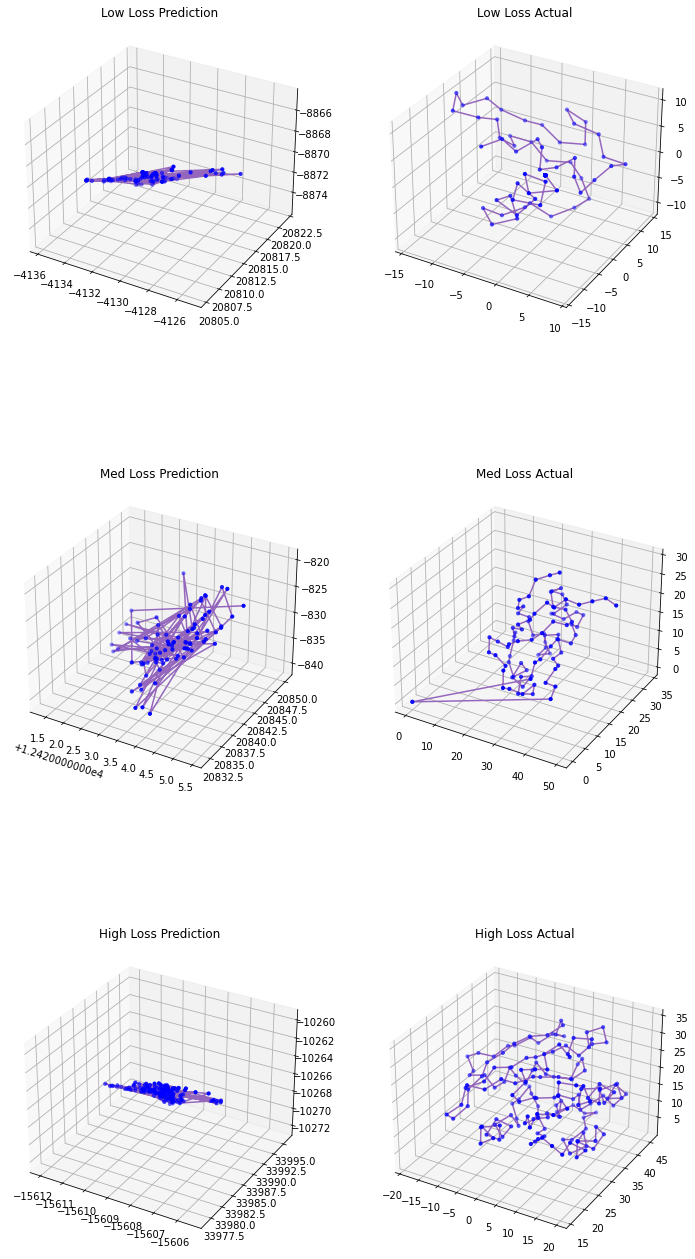

In [21]:
test_loss = 0.
pred_coords_dict = {}
true_coords_dict = {}
loss_list = []
model.eval()
with torch.no_grad():
    for bidx, (batch) in enumerate(tqdm(data_eval['test'])):
        seqs, evos, angs, masks, c_alpha, n, c = get_seq_features(batch)
        seqs, evos, angs, masks, c_alpha, n, c = seqs.to(device), evos.to(device), angs.to(device), masks.to(device), c_alpha.to(device), n.to(device), c.to(device)
        T, cds, p_phi, p_psi, loss = model(seqs.type(torch.float), evos, n, c_alpha, c, angs[:,:,:2], angs[:,:,2:], masks)
        loss_list.append(loss)
        pred_coords_dict[loss] = cds
        true_coords_dict[loss] = c_alpha
        test_loss += loss.item()
    print(f"Avg Loss: {test_loss/len(data_eval['test']):.6f}") 
    loss_list.sort()
    fig = plt.figure(figsize=(12, 24))
    cds = pred_coords_dict[loss_list[0]].cpu().detach().numpy()
    c_alpha = true_coords_dict[loss_list[0]].cpu().detach().numpy()
    print(f"Low loss: {loss_list[0].item()}")
    xyz = (cds[0,:,0], cds[0,:,1], cds[0,:,2])
    ax = fig.add_subplot(321, projection="3d")
    ax.scatter(cds[0,:,0], cds[0,:,1], cds[0,:,2],c='b',s=10)
    ax.plot(cds[0,:,0], cds[0,:,1], cds[0,:,2], color='tab:purple')
    ax.set_title("Low Loss Prediction")
    ay = fig.add_subplot(322, projection="3d")
    ay.scatter(c_alpha[0,:,0], c_alpha[0,:,1], c_alpha[0,:,2],c='b',s=10)
    ay.plot(c_alpha[0,:,0], c_alpha[0,:,1], c_alpha[0,:,2], color='tab:purple')
    ay.set_title("Low Loss Actual")
    cds = pred_coords_dict[loss_list[len(loss_list)//2]].cpu().detach().numpy()
    c_alpha = true_coords_dict[loss_list[len(loss_list)//2]].cpu().detach().numpy()
    print(f"Med loss: {loss_list[len(loss_list)//2].item()}")
    xyz = (cds[0,:,0], cds[0,:,1], cds[0,:,2])
    bx = fig.add_subplot(323, projection="3d")
    bx.scatter(cds[0,:,0], cds[0,:,1], cds[0,:,2],c='b',s=10)
    bx.plot(cds[0,:,0], cds[0,:,1], cds[0,:,2], color='tab:purple')
    bx.set_title("Med Loss Prediction")
    by = fig.add_subplot(324, projection="3d")
    by.scatter(c_alpha[0,:,0], c_alpha[0,:,1], c_alpha[0,:,2],c='b',s=10)
    by.plot(c_alpha[0,:,0], c_alpha[0,:,1], c_alpha[0,:,2], color='tab:purple')
    by.set_title("Med Loss Actual")
    cds = pred_coords_dict[loss_list[len(loss_list)-1]].cpu().detach().numpy()
    c_alpha = true_coords_dict[loss_list[len(loss_list)-1]].cpu().detach().numpy()
    print(f"High loss: {loss_list[len(loss_list)-1].item()}")
    xyz = (cds[0,:,0], cds[0,:,1], cds[0,:,2])
    cx = fig.add_subplot(325, projection="3d")
    cx.scatter(cds[0,:,0], cds[0,:,1], cds[0,:,2],c='b',s=10)
    cx.plot(cds[0,:,0], cds[0,:,1], cds[0,:,2], color='tab:purple')
    cx.set_title("High Loss Prediction")
    cy = fig.add_subplot(326, projection="3d")
    cy.scatter(c_alpha[0,:,0], c_alpha[0,:,1], c_alpha[0,:,2],c='b',s=10)
    cy.plot(c_alpha[0,:,0], c_alpha[0,:,1], c_alpha[0,:,2], color='tab:purple')
    cy.set_title("High Loss Actual")
    plt.show()